In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

from astropy.io import fits
import fitsio
import sqlite3

In [2]:
import lightkurve as lk
from scipy import stats
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import simple_norm

In [3]:
from roman_lcs import Machine, RomanMachine

In [4]:
PATH = "/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01"

In [5]:
FILTER = "F146"
FIELD = 3

ff = sorted(glob(f"{PATH}/simulated_image_data/rimtimsim_WFI_lvl02_{FILTER}_SCA02_field{FIELD:02}_rampfitted_exposureno_*_sim.fits"))
len(ff)

3298

In [17]:
ff[:3]

['/Users/jimartin/Work/ROMAN/simulations/dryrun_01/imgs/rimtimsim_WFI_lvl02_F146_SCA02_field03_rampfitted_exposureno_000000003_sim.fits',
 '/Users/jimartin/Work/ROMAN/simulations/dryrun_01/imgs/rimtimsim_WFI_lvl02_F146_SCA02_field03_rampfitted_exposureno_000000011_sim.fits',
 '/Users/jimartin/Work/ROMAN/simulations/dryrun_01/imgs/rimtimsim_WFI_lvl02_F146_SCA02_field03_rampfitted_exposureno_000000019_sim.fits']

In [11]:
cutout_size = 256
cutout_origin = (0, 0)
mag_limit = 21

with sqlite3.connect(f"{PATH}/metadata/TRExS_dryrun_01_MASTER_input_catalog_v1.1.db") as conn:
        query = (
            f"F146 <= {mag_limit} and "
            f"MEAN_XCOL >= {cutout_origin[0]} and MEAN_XCOL <= {cutout_origin[0] + cutout_size} and "
            f"MEAN_YCOL >= {cutout_origin[1]} and MEAN_YCOL <= {cutout_origin[1] + cutout_size}"
        )
        sources = pd.read_sql_query(
            f"SELECT * FROM Master_input_catalog WHERE {query}", conn
        ).reset_index(drop=False)
sources = sources.rename(
        columns={
            "RA_DEG": "ra",
            "DEC_DEG": "dec",
            "MEAN_XCOL": "column",
            "MEAN_YCOL": "row",
            f"{FILTER}_flux": "flux",
            f"{FILTER}_flux_err": "flux_err",
        }
    )
sources

index  sicbro_id          ra        dec      column         row  \
0         0         35  268.410148 -29.222950  167.782099  202.049921   
1         1        113  268.406220 -29.221591   47.426612  183.048594   
2         2        115  268.406408 -29.227054  141.793911   25.034426   
3         3        210  268.408010 -29.226215  168.012909   73.796614   
4         4        262  268.407097 -29.219692   38.138947  252.143209   
...     ...        ...         ...        ...         ...         ...   
1802   1802    4972542  268.404976 -29.224765   68.466112   70.914880   
1803   1803    4972691  268.410126 -29.223340  173.636603  190.221979   
1804   1804    4972701  268.409885 -29.225302  199.841973  128.842027   
1805   1805    4972810  268.403445 -29.226154   53.043382    7.014416   
1806   1806    4972939  268.410370 -29.223163  176.841303  199.110217   

         F062     F087     F106     F129  ...  lowmassEB  lowRedNoise  \
0     18.8842  17.8611  17.3982  16.9352  ...          0            0   
1     23.3471  21.7634  21.0401  20.3168  ...          0            0   
2     20.1243  19.0027  18.5486  18.0945  ...          0            0   
3     22.1282  20.6838  20.0522  19.4205  ...          0            0   
4     22.1393  20.7701  20.1597  19.5492  ...          0            0   
...       ...      ...      ...      ...  ...        ...          ...   
1802  20.4099  19.6291  19.3872  19.1453  ...          0            0   
1803  17.3685  16.5049  16.1261  15.7474  ...          0            0   
1804  20.3563  19.6350  19.4124  19.1897  ...          0            0   
1805  19.9806  19.2192  18.9479  18.6766  ...          0            1   
1806  20.1123  19.3522  19.0548  18.7574  ...          0            0   

      hiRedNoise  variable     F087_flux  F087_flux_err          flux  \
0              0         0   7430.305463      86.199220  17891.496514   
1              0         0    204.214544      14.290365    811.496532   
2              0         0   2596.370513      50.954593   6342.298353   
3              0         1    551.984227      23.494345   1853.901553   
4              1         1    509.808026      22.578929   1645.609054   
...          ...       ...           ...            ...           ...   
1802           0         0   1458.164995      38.185927   2339.950488   
1803           0         0  25911.148788     160.969403  56317.927988   
1804           0         0   1450.262669      38.082314   2202.960287   
1805           0         1   2126.995975      46.119367   3722.259681   
1806           0         0   1881.770553      43.379379   3436.898196   

        flux_err     F213_flux  F213_flux_err  
0     133.759099  16099.287948     126.882969  
1      28.486778    775.258735      27.843468  
2      79.638548   5726.465758      75.673415  
3      43.056957   1741.833617      41.735280  
4      40.566107   1524.637748      39.046610  
...          ...           ...            ...  
1802   48.373035   2064.841252      45.440524  
1803  237.313986  52091.476589     228.235573  
1804   46.935704   1901.457698      43.605707  
1805   61.010324   3338.002581      57.775450  
1806   58.625065   3072.180075      55.427250  

[1807 rows x 27 columns]

# PSFMachine

## Build PRF mdoel with full data and $mag < 21$

In [13]:
mac = RomanMachine.from_file(
    ff[:1], 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux",
    cutout_size=cutout_size,
    cutout_origin=cutout_origin,
)
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

Creating delta arrays: 100%|████████████████████████████████████████████████████████| 1807/1807 [00:01<00:00, 1331.07it/s]


RomanMachine (N sources, N times, N pixels): (1807, 1, 65536)

In [14]:
mac.image_shape

(256, 256)

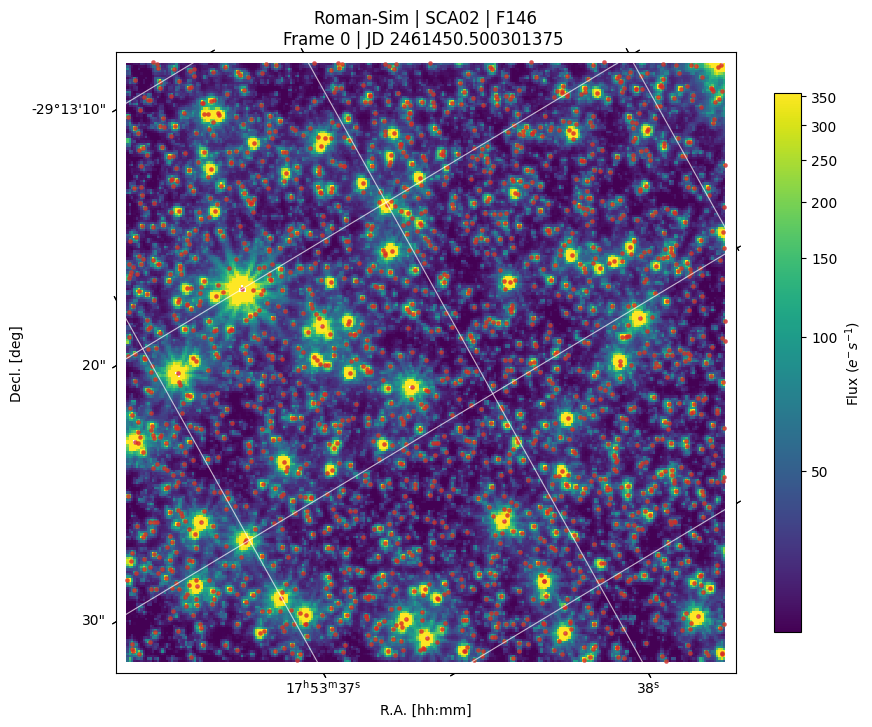

In [16]:
mac.plot_image(sources=True, frame_index=0);

In [21]:
examples = np.random.choice(mac.sources.query("F146 < 19").index.values, size=7*7)
examples

array([ 617,   26, 6719,  402,  226, 6556, 6750, 6749, 7203, 7023, 1139,
       7140, 6882, 7364, 7144, 7319,  576, 6068, 7132,  947, 6048,  458,
       1816, 6948,  301, 7157, 5970, 7386, 1132,  549, 7215, 7225, 7255,
       7047, 7105, 7280, 7204, 7328, 7115, 6836, 7253, 7409,  695, 3801,
        106, 6068, 1273, 7251,  301])

Creating delta arrays: 100%|██████████| 7411/7411 [00:23<00:00, 321.27it/s]
/home/jorgemarpa/envs/conda/roman-psfmachine/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


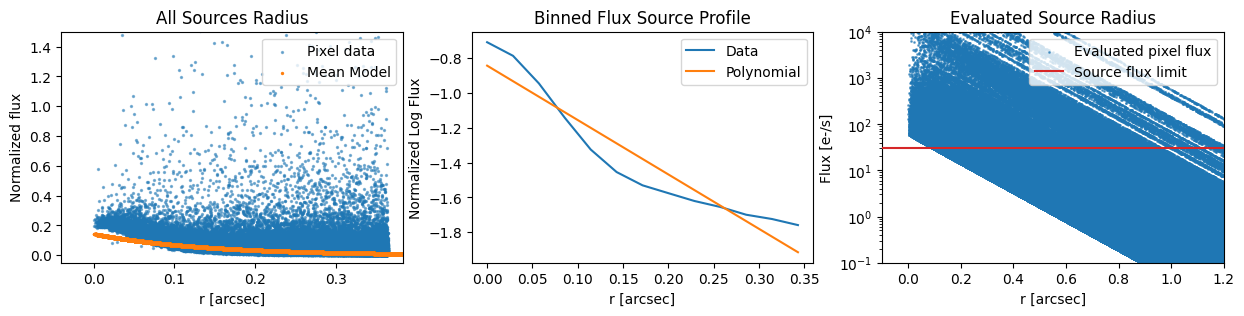

In [22]:
mac._get_source_mask(source_flux_limit=30, plot=True, reference_frame=0, iterations=1)

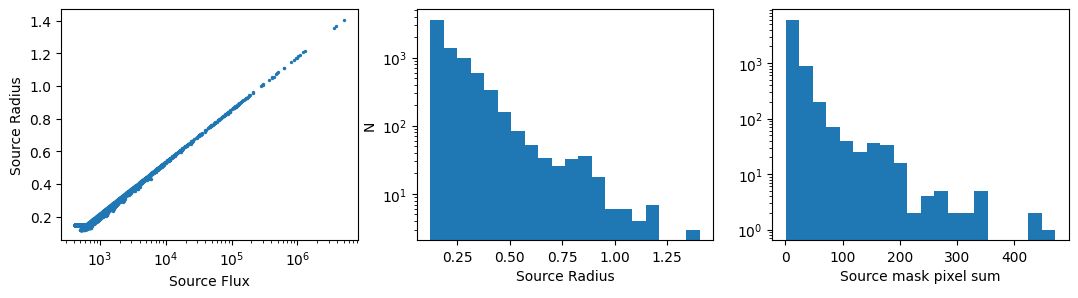

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3))

ax[0].scatter(mac.sources.flux, mac.radius, s=2)
ax[0].set_xlabel("Source Flux")
ax[0].set_ylabel("Source Radius")
ax[0].set_xscale("log")

ax[1].hist(mac.radius, bins=20)
ax[1].set_xlabel("Source Radius")
ax[1].set_ylabel("N")
ax[1].set_yscale("log")

ax[2].hist(np.array(mac.source_mask.sum(axis=1)).ravel(), bins=20)
ax[2].set_xlabel("Source mask pixel sum")
ax[2].set_yscale("log")

plt.show()

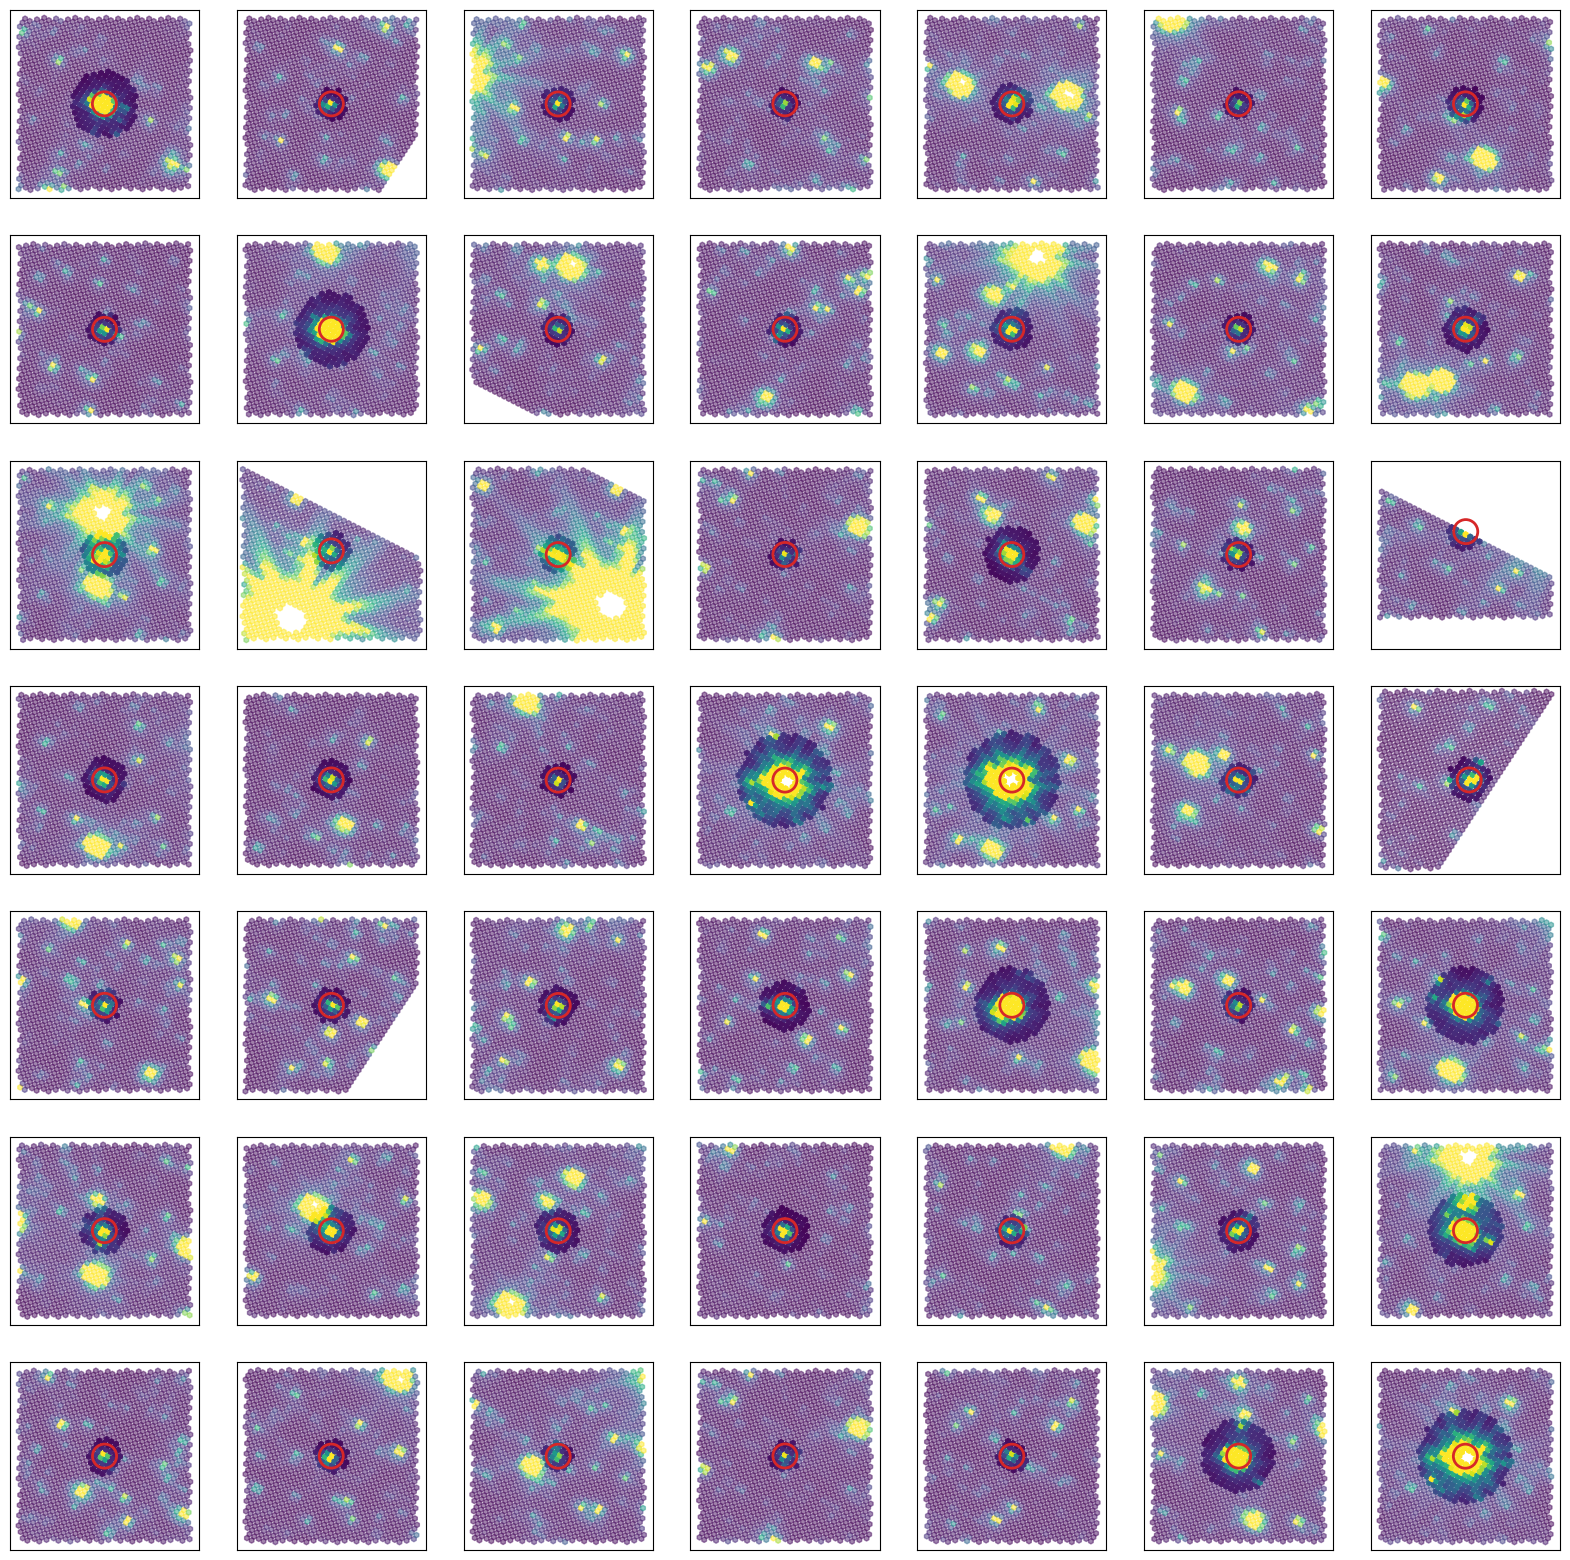

In [24]:
flux_masked = mac.r.astype(bool).multiply(mac.flux[0]).tocsr()

source_mask_dx = mac.source_mask.multiply(mac.dra).tocsr()
source_mask_dy = mac.source_mask.multiply(mac.ddec).tocsr()
source_mask_flux = mac.source_mask.multiply(mac.flux[0]).tocsr()

fig, ax = plt.subplots(7, 7, figsize=(20,20))

for i, k in enumerate(examples):
    ax.ravel()[i].scatter(mac.dra[k].data*3600, 
                          mac.ddec[k].data*3600, 
                          s=15, marker="h", 
                          c=flux_masked[k].data, 
                          alpha=0.5,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(source_mask_dx[k].data*3600, 
                          source_mask_dy[k].data*3600, 
                          s=15, marker="h", 
                          c=source_mask_flux[k].data, 
                          alpha=1,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(0, 0, s=300, edgecolor="tab:red", marker="o", facecolor="none", lw=2)
    ax.ravel()[i].axis('equal')
    ax.ravel()[i].set_xticks([])
    ax.ravel()[i].set_yticks([])
plt.show()

In [25]:
mac.rough_mask

<7411x262144 sparse matrix of type '<class 'numpy.bool_'>'
	with 231519 stored elements in Compressed Sparse Row format>

In [26]:
mac.source_mask, mac.uncontaminated_source_mask

(<7411x262144 sparse matrix of type '<class 'numpy.bool_'>'
 	with 130768 stored elements in Compressed Sparse Row format>,
 <7411x262144 sparse matrix of type '<class 'numpy.bool_'>'
 	with 78027 stored elements in Compressed Sparse Row format>)

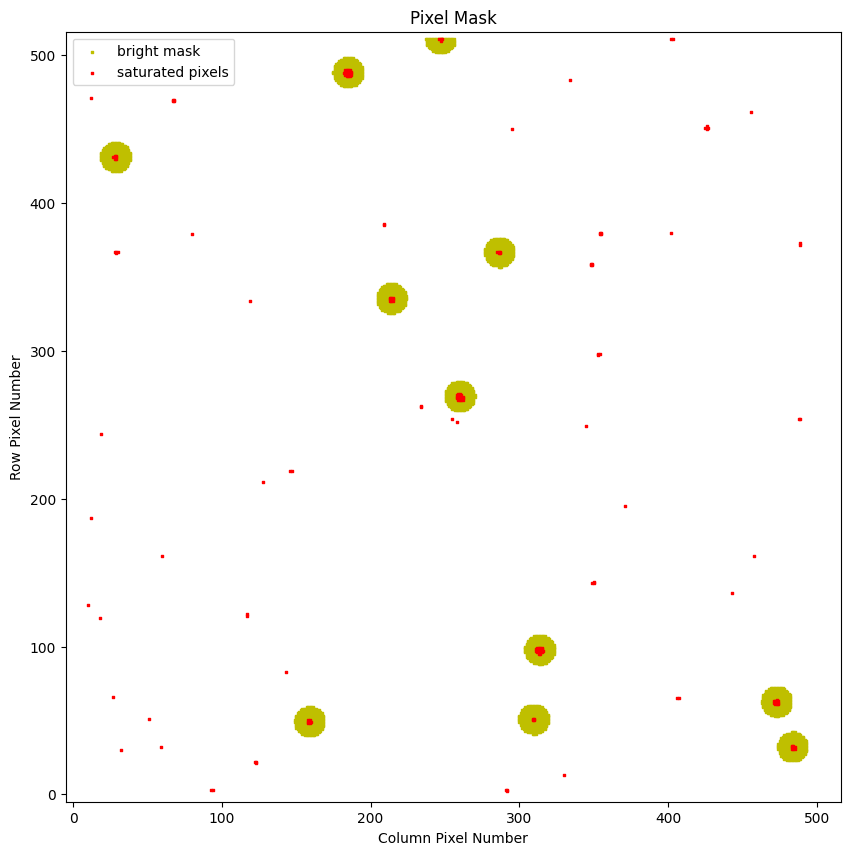

In [27]:
# mac._mask_pixels(magnitude_bright_limit=13)
_ = mac.plot_pixel_masks()

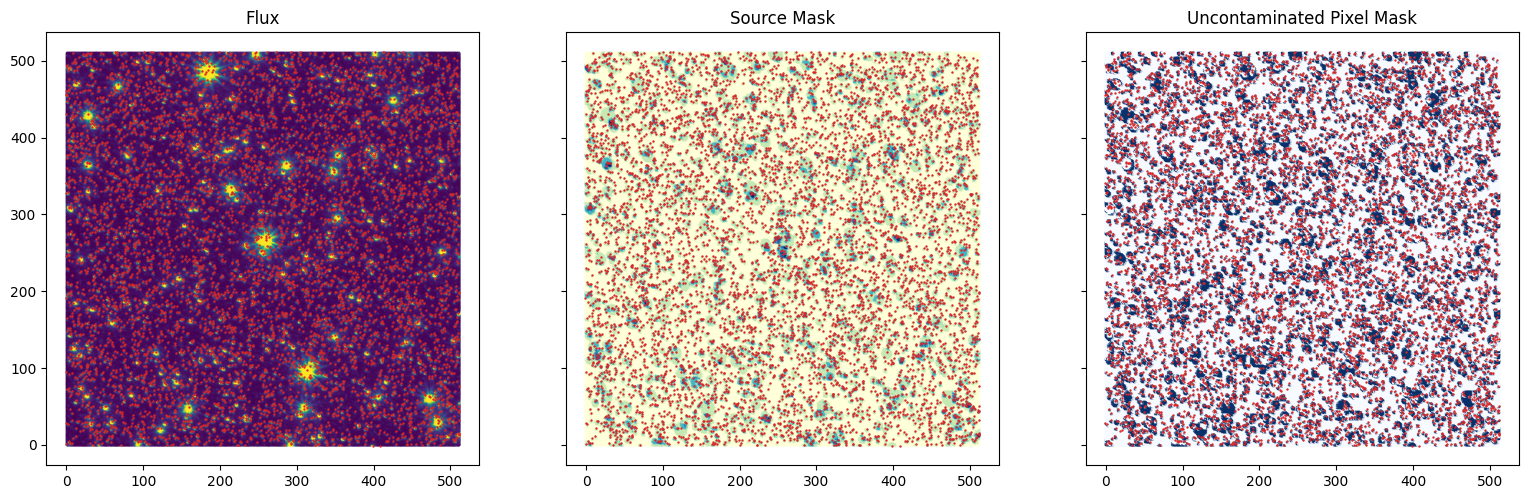

In [28]:
# mac._update_source_mask(frame_index=mac.ref_frame)
ROW, COL = mac.pixel_coordinates(mac.ref_frame)

fig, ax = plt.subplots(1, 3, figsize=(19, 9), sharex=True, sharey=True)

ax[0].set_title("Flux")
ax[0].scatter(
    mac.column,
    mac.row,
    c=mac.flux[mac.ref_frame], 
    vmin=10, 
    vmax=500,
    s=1,
    marker="s",
)
ax[0].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[1].set_title("Source Mask")
ax[1].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=4,
    alpha=1,
    cmap="YlGnBu",
    s=1,
    marker="s",
)
ax[1].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[2].set_title("Uncontaminated Pixel Mask")
ax[2].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.uncontaminated_source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=1,
    alpha=1,
    cmap="Blues",
    s=1,
    marker="s",
)
ax[2].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[0].set_aspect("equal", adjustable="box")
ax[1].set_aspect("equal", adjustable="box")
ax[2].set_aspect("equal", adjustable="box")

plt.show()

Creating delta arrays: 100%|██████████| 7411/7411 [00:22<00:00, 324.15it/s]
/home/jorgemarpa/envs/conda/roman-psfmachine/lib/python3.9/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


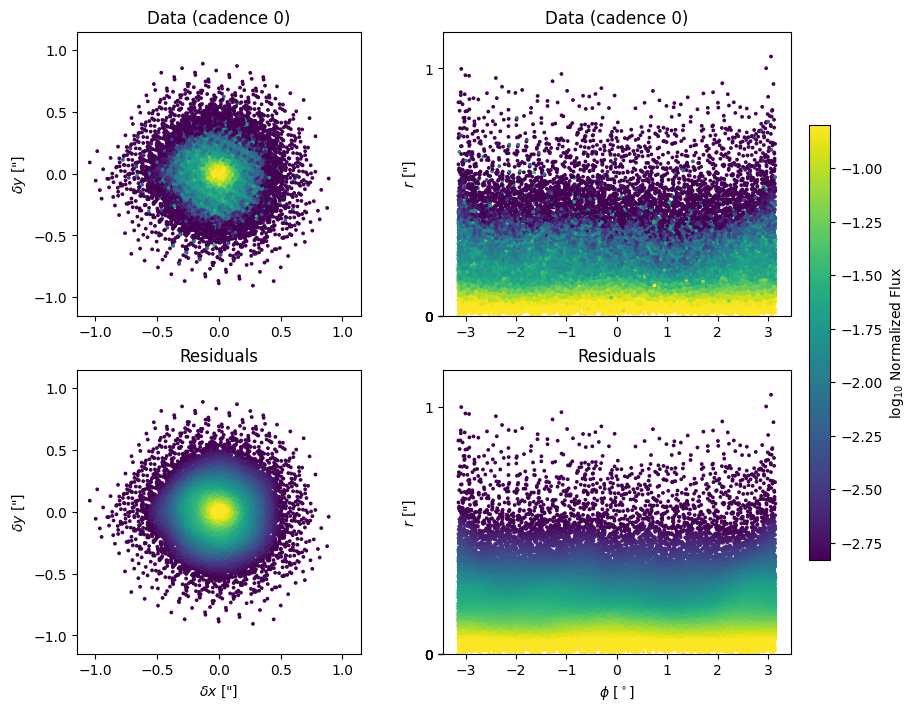

In [29]:
mac.rmin = 0.02
mac.rmax = 0.8
mac.cut_r = 0.2
mac.n_r_knots = 9
mac.n_phi_knots = 15
psf_tdx = 0

mac.build_shape_model(
    plot=True,
    flux_cut_off=0.2,
    frame_index=psf_tdx,
    bin_data=False,
)
plt.show()

In [30]:
output = f"./data/roman_WFI_{mac.meta['READMODE']}_{mac.meta['FILTER']}_{mac.meta['DETECTOR']}_shape_model_cad{psf_tdx}.fits"
mac.save_shape_model(output=output)

In [32]:
mac.quiet = True
mac.fit_model()

Fitting 7411 Sources (w. VA): 100%|██████████| 1/1 [01:20<00:00, 80.60s/it]


In [35]:
np.nansum(mac.ws)

0.0

## Evaluate Model on substamp with full catalog

In [8]:
cutout_size = 32
cutout_origin = (0, 0)
mag_limit = 23

with sqlite3.connect(f"{PATH}/metadata/TRExS_dryrun_01_MASTER_input_catalog_v1.1.db") as conn:
        query = (
            f"F146 <= {mag_limit} and "
            f"MEAN_XCOL >= {cutout_origin[0]} and MEAN_XCOL <= {cutout_origin[0] + cutout_size} and "
            f"MEAN_YCOL >= {cutout_origin[1]} and MEAN_YCOL <= {cutout_origin[1] + cutout_size}"
        )
        sources = pd.read_sql_query(
            f"SELECT * FROM Master_input_catalog WHERE {query}", conn
        ).reset_index(drop=False)
sources = sources.rename(
        columns={
            "RA_DEG": "ra",
            "DEC_DEG": "dec",
            "MEAN_XCOL": "column",
            "MEAN_YCOL": "row",
            f"{FILTER}_flux": "flux",
            f"{FILTER}_flux_err": "flux_err",
        }
    )
sources

index  sicbro_id          ra        dec     column        row     F062  \
0        0      38560  268.402388 -29.224992   7.597485  25.345666  23.5873   
1        1      56432  268.402118 -29.225187   4.042815  15.566227  24.2162   
2        2      76952  268.402773 -29.225427  24.347549  18.324143  24.8468   
3        3     146697  268.402686 -29.224936  14.092888  31.491211  19.1213   
4        4     206257  268.402828 -29.225726  30.615170  10.364126  22.0602   
..     ...        ...         ...        ...        ...        ...      ...   
101    101    4807060  268.403024 -29.225171  26.408753  29.638878  21.1395   
102    102    4830080  268.402485 -29.225157  12.710073  21.945738  21.1608   
103    103    4843921  268.401909 -29.225515   4.222192   2.764865  20.1471   
104    104    4871131  268.402864 -29.225236  23.478773  25.325750  20.5865   
105    105    4896480  268.401917 -29.225429   3.005735   5.402175  19.6881   

        F087     F106     F129  ...  lowmassEB  lowRedNoise  hiRedNoise  \
0    22.3959  21.8824  21.3690  ...          0            0           1   
1    23.0791  22.6156  22.1522  ...          0            0           0   
2    23.6880  23.2286  22.7692  ...          0            0           0   
3    18.5568  18.4325  18.3083  ...          0            0           0   
4    21.2743  20.9681  20.6618  ...          0            0           0   
..       ...      ...      ...  ...        ...          ...         ...   
101  20.4588  20.2508  20.0428  ...          0            0           1   
102  20.5768  20.4164  20.2560  ...          0            0           1   
103  19.4627  19.2779  19.0932  ...          0            0           0   
104  19.8727  19.6839  19.4951  ...          0            0           0   
105  19.0806  18.9294  18.7782  ...          0            0           0   

     variable    F087_flux  F087_flux_err         flux   flux_err  \
0           1   114.047736      10.679313   322.646284  17.962357   
1           0    60.786434       7.796566   154.328689  12.422910   
2           0    34.693384       5.890109    88.333750   9.398604   
3           0  3914.954042      62.569594  4598.822719  67.814620   
4           0   320.425203      17.900425   604.458749  24.585743   
..        ...          ...            ...          ...        ...   
101         1   679.088957      26.059335  1011.688162  31.807046   
102         1   609.153394      24.681033   797.786473  28.245114   
103         0  1699.678059      41.227152  2365.956024  48.641094   
104         1  1165.109298      34.133697  1647.580595  40.590400   
105         0  2416.610556      49.159033  3059.755106  55.315053   

       F213_flux  F213_flux_err  
0     312.987266      17.691446  
1     148.527431      12.187183  
2      85.768274       9.261116  
3    3678.295943      60.648957  
4     552.951026      23.514911  
..           ...            ...  
101   870.415604      29.502807  
102   657.849681      25.648580  
103  2001.182370      44.734577  
104  1409.050856      37.537326  
105  2495.322417      49.953202  

[106 rows x 27 columns]

In [73]:
mac = RomanMachine.from_file(
    ff, 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux",
    cutout_size=cutout_size,
    cutout_origin=[0, 0],
)
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

100%|████████████████████████████████████████████████████████████████████████████████| 3298/3298 [00:19<00:00, 173.33it/s]


RomanMachine (N sources, N times, N pixels): (106, 3298, 1024)

In [74]:
mac.image_shape

(32, 32)

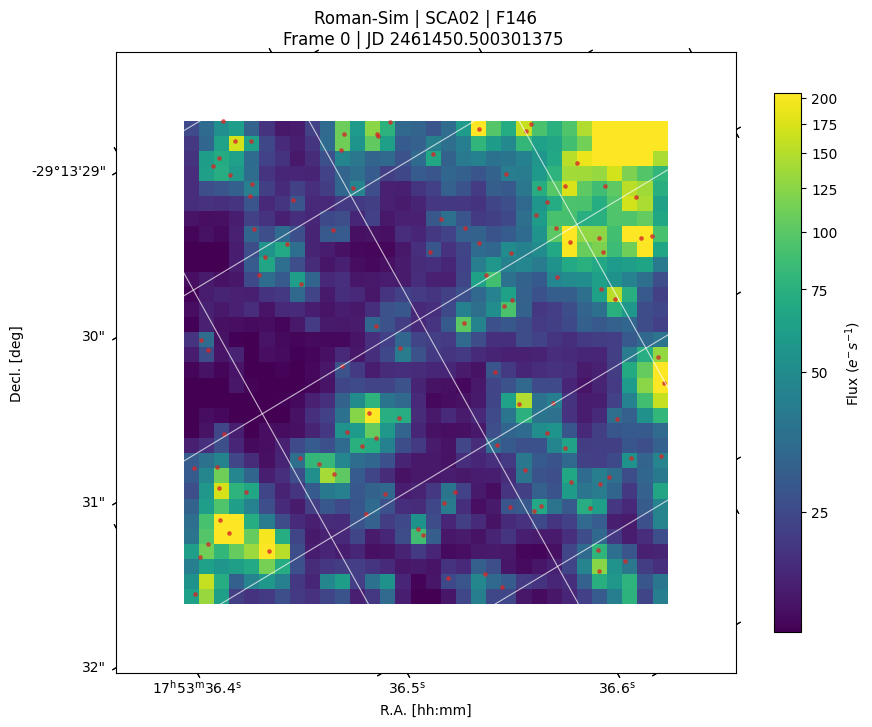

In [14]:
mac.plot_image(sources=True);

In [15]:
mac.meta

{'MISSION': 'Roman-Sim',
 'TELESCOP': 'Roman',
 'SOFTWARE': 'rimtimsim_v2.0',
 'RADESYS': 'FK5',
 'EQUINOX': 2000.0,
 'FILTER': 'F146',
 'FIELD': 1,
 'DETECTOR': 'SCA02',
 'EXPOSURE': 54.72,
 'READMODE': 'ramp'}

/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


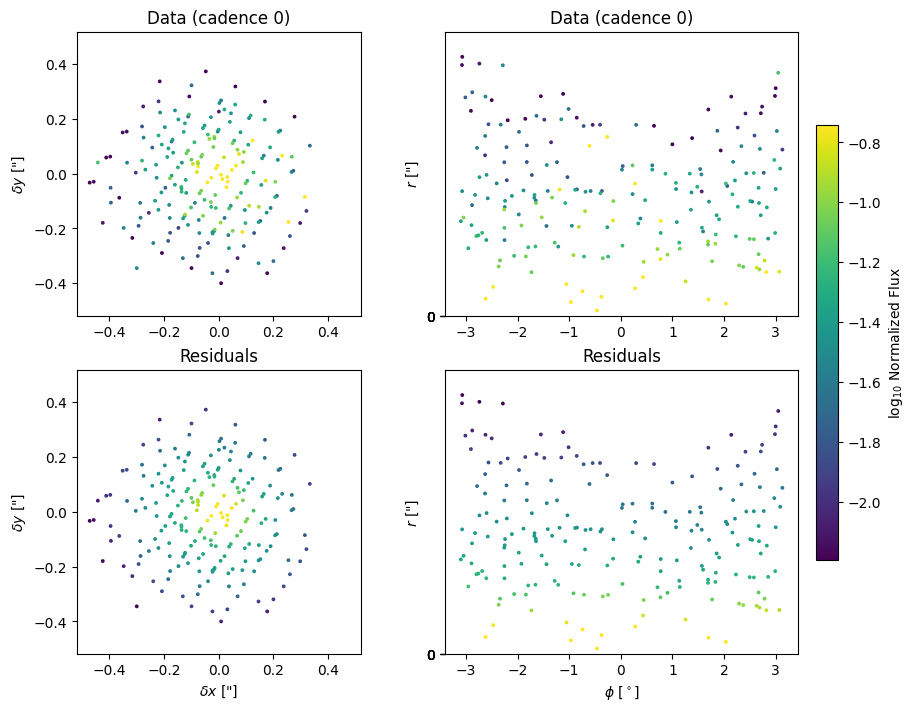

In [75]:
prf_origin = (1792, 1792)
DATPATH = "/Users/jimartin/Work/ROMAN/TRExS/Roman-lcs/data"
prf_fname = (
    f"{DATPATH}/prf_models/"
    f"roman_WFI_{mac.meta['READMODE']}_{mac.meta['FILTER']}"
    f"_{mac.meta['FIELD']}_{mac.meta['DETECTOR']}_shape_model_cad{0}"
    f"_row{prf_origin[0]}-col{prf_origin[1]}_size256.fits"
)

mac.load_shape_model(prf_fname, flux_cut_off=0.2, plot=True, source_flux_limit=50);

In [38]:
from roman_lcs.utils import solve_linear_model
import tensorflow as tf

In [76]:
%%time
mac.fit_model()

Fitting 106 Sources (w. VA): 100%|████████████████████████████████████████████████████| 3298/3298 [01:21<00:00, 40.65it/s]

CPU times: user 8min 41s, sys: 7min 3s, total: 15min 45s
Wall time: 1min 21s


In [77]:
prior_mu = mac.source_flux_estimates  # np.zeros(A.shape[1])
prior_sigma = (
    np.ones(mac.mean_model.shape[0])
    * 5
    * np.abs(mac.source_flux_estimates) ** 0.5
)

In [78]:
%%time
model_flux = np.zeros(mac.flux.shape) * np.nan
# ws = np.zeros((mac.nt, mac.mean_model.shape[0]))
# werrs = np.zeros((mac.nt, mac.mean_model.shape[0]))
fit_quality = np.zeros(mac.nt)

sigma_w_invs = []
Bs = []

for tdx in tqdm(
    range(mac.nt),
    desc=f"Fitting {mac.nsources} Sources (w. VA)",
    # disable=mac.quiet,
):
    # update source mask for current frame
    mac._update_source_mask(frame_index=tdx)
    mac._get_mean_model()
    mac._update_source_mask_remove_bkg_pixels(
        flux_cut_off=mac.flux_cut_off, frame_index=tdx
    )
    X = mac.mean_model.copy()
    X = X.T

    sigma_w_invs.append(X.T.dot(X.multiply(1 / mac.flux_err[tdx][:, None] ** 2)) + np.diag(1/prior_sigma**2))
    Bs.append(X.T.dot(mac.flux[tdx] / mac.flux_err[tdx] ** 2) + prior_mu/prior_sigma**2)

sigma_w_invs = np.asarray(sigma_w_invs)
Bs = np.asarray(Bs)

wst = tf.linalg.solve(sigma_w_invs, Bs[:, :, None]).numpy()
werrst = tf.linalg.inv(sigma_w_invs).numpy()

# check bad estimates
nodata = np.asarray(mac.mean_model.sum(axis=1))[:, 0] == 0
# These sources are poorly estimated
# nodata |= (mac.mean_model.max(axis=1) > 1).toarray()[:, 0]
wst[:, nodata] *= np.nan
werrst[:, nodata] *= np.nan

Fitting 106 Sources (w. VA): 100%|████████████████████████████████████████████████████| 3298/3298 [01:18<00:00, 41.84it/s]


CPU times: user 6min 50s, sys: 8min 21s, total: 15min 11s
Wall time: 1min 19s


In [68]:
X.multiply(1 / mac.flux_err[tdx][:, None] ** 2)

<COOrdinate sparse matrix of dtype 'float64'
	with 810 stored elements and shape (1024, 106)>

In [36]:
sigma_w_invs.shape, Bs.shape

((200, 106, 106), (200, 106))

In [37]:
%%time
ws = np.linalg.solve(sigma_w_invs, Bs)

CPU times: user 56.8 s, sys: 10.8 s, total: 1min 7s
Wall time: 8.98 s


In [41]:
Bs[:, :, None].shape

(200, 106, 1)

In [42]:
%%time
wst = tf.linalg.solve(sigma_w_invs, Bs[:, :, None])

CPU times: user 28 ms, sys: 14.7 ms, total: 42.6 ms
Wall time: 17.9 ms


In [45]:
np.isclose(ws, wst.numpy().reshape(ws.shape))

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [57]:
mac.ws - wst.numpy().reshape(ws.shape)

array([[  -5.12063361,  -37.78697469,    1.89566413, ...,  -88.24833272,
          36.30954545, -652.20350798],
       [   2.8575768 ,  -13.89832623,    7.48868958, ...,   68.91770248,
           6.22357731, -668.40190358],
       [   2.58496146,   28.70455824,   -1.54591746, ..., -264.91899596,
         -27.94674289, -476.83870969],
       ...,
       [   1.6071189 ,   -8.98765451,    7.35525236, ..., -339.61354205,
          26.0670863 , -474.01531391],
       [   4.06974029,   25.98781845,    3.50819261, ...,  -35.00589582,
          21.29494056, -739.76139912],
       [  -1.10634389,   31.93107027,    3.32160803, ..., -339.24693285,
         -64.53065492, -511.62191412]])

In [55]:
np.isclose(mac.ws, wst.numpy().reshape(ws.shape))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])